In [1]:
#!pip install transformers

In [2]:
#!pip install torch

In [3]:
#!pip install torch==1.13.1

In [4]:
#!pip install datasets

In [5]:
#!pip install clip

In [6]:
import os
import torch
import skimage
import requests
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import IPython.display
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
import json
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import clip
import zipfile

Loading the csv file containing selected articles after EDA

In [7]:
articles=pd.read_csv('selected_articles.csv',index_col=0)

In [8]:
# Adding the missing 0 to the article id and converting it to string as per the original dataset
articles['article_id'] = articles['article_id'].astype(str)
articles['article_id']=["0"+x for x in articles['article_id']]

Get the image path corresponding to each article id from zipped folders. We're adding the paths to the dataframe in a separate column.
This will be used later to load the images during model training

In [10]:
zip_file_path_1='H&M_dataset/selected_images_1.zip'
zip_file_path_2='H&M_dataset/selected_images.zip'

with zipfile.ZipFile(zip_file_path_1, 'r') as zip_ref:
        files_in_zip_1 = zip_ref.namelist()
        
with zipfile.ZipFile(zip_file_path_2, 'r') as zip_ref:
        files_in_zip_2 = zip_ref.namelist()

df['image_path'] = None

article_ids_1 = [file.split('/')[1].split('.')[0] for file in files_in_zip_1]
article_ids_2 = [file.split('/')[1].split('.')[0] for file in files_in_zip_2]

# Create a dictionary to map article IDs to file paths
id_to_path_mapping_1 = {file.split('/')[1].split('.')[0]: file for file in files_in_zip_1}
id_to_path_mapping_2 = {file.split('/')[1].split('.')[0]: file for file in files_in_zip_2}

id_to_path_mapping_1.update(id_to_path_mapping_2)

# Update the image_path column using vectorized operations
df['image_path'] = df['article_id'].map(id_to_path_mapping_1)

In [15]:
df

,article_id,caption,image_path
0,0108775015,"womens Solid Black Vest top, Jersey top with n...",selected_images_1/0108775015.jpg
1,0108775044,"womens Solid White Vest top, Jersey top with n...",selected_images_1/0108775044.jpg
2,0108775051,"womens Stripe Off White Vest top, Jersey top w...",selected_images_1/0108775051.jpg
3,0111586001,"womens Solid Black Leggings, Tights with built...",selected_images_1/0111586001.jpg
6,0116379047,"womens Solid Dark Blue Top, Fitted top in soft...",selected_images_1/0116379047.jpg
...,...,...,...
84371,0952937003,"womens All over pattern Beige Dress, Fitted, c...",selected_images/0952937003.jpg
84372,0952938001,"womens All over pattern Beige Top, Fitted top ...",selected_images/0952938001.jpg
84373,0953763001,"womens Solid Black Vest top, Loose-fitting spo...",selected_images/0953763001.jpg
84374,0956217002,"womens Solid Black Dress, Short, A-line dress ...",selected_images/0956217002.jpg


Dropping NA values

In [17]:
df_cleaned = df.dropna()

Splitting into train, validation and test datasets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df_cleaned['image_path'], df_cleaned['caption'], test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

train_data = pd.DataFrame({'image_path':X_train.values, 'caption': y_train.values})
val_data = pd.DataFrame({'image_path':X_val.values, 'caption': y_val.values})
test_data = pd.DataFrame({'image_path':X_test.values, 'caption': y_test.values})

Here we define a few functions and a class to load the CLIP model and prepare the dataset

In [25]:
def get_model_info(model_ID, device):
    # Save the model to device
    model = CLIPModel.from_pretrained(model_ID).to(device)
    # Get the processor
    processor = CLIPProcessor.from_pretrained(model_ID)
    # Get the tokenizer
    tokenizer = CLIPTokenizer.from_pretrained(model_ID)
       # Return model, processor & tokenizer
    return model, processor, tokenizer
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
# Define the model ID
model_ID = "openai/clip-vit-base-patch32"
# Get model, processor & tokenizer
model, processor, tokenizer = get_model_info(model_ID, device)

In [21]:
z1 = zipfile.ZipFile('H&M_dataset/selected_images_1.zip')
z2 = zipfile.ZipFile('H&M_dataset/selected_images.zip')

def get_image(image_path_inside_zip):
    if image_path_inside_zip in z1.namelist():
        # Extract the specific image file
        image = z1.read(image_path_inside_zip)

    elif image_path_inside_zip in z2.namelist():
        image = z2.read(image_path_inside_zip)
        
    #image = Image.open(BytesIO(image)).convert("RGB")
    return image

In [23]:
class image_title_dataset():
    def __init__(self, list_image_path,list_txt):
        # Initialize image paths and corresponding texts
        self.image_path = list_image_path
        self.title  = list_txt

    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):

        return self.image_path[idx], self.title[idx]

Prepare the dataset and create a dataloader object out of it

In [42]:
# use your own data
list_image_path_train = []
list_txt_train = []
list_image_path_val = []
list_txt_val = []

for index,item in train_data.iterrows():
    if index==500:
        break
    img_path = item['image_path'] #+ item['image_path'].split('/')[-1]
    #print(img_path)
    #print(item['caption'][:40])
    caption = item['caption'][:77]
    list_image_path_train.append(img_path)
    list_txt_train.append(caption)
    
for index,item in val_data.iterrows():
    if index==100:
        break
    img_path = item['image_path'] #+ item['image_path'].split('/')[-1]
    #print(img_path)
    caption = item['caption'][:77]
    list_image_path_val.append(img_path)
    list_txt_val.append(caption)

In [43]:
train_dataset = image_title_dataset(list_image_path_train, list_txt_train)
val_dataset = image_title_dataset(list_image_path_val, list_txt_val)

train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True) #Define your own dataloader
val_dataloader = DataLoader(val_dataset, batch_size=10, shuffle=True)

In [28]:
# first_batch = next(iter(train_dataloader))

# # Print the first batch
# print(first_batch[0][0])
# x=[]
# x.append(Image.open(BytesIO(get_image(first_batch[0][0]))).convert("RGB").resize((100, 100)))

# next_batch = next(iter(train_dataloader))

# x.append(Image.open(BytesIO(get_image(next_batch[0][0]))).convert("RGB").resize((100, 100)))

Set model parameters

In [29]:
#Function to convert model's parameters to FP32 format
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 


if device == "cpu":
    model.float()

# Prepare the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2) # the lr is smaller, more safe for fine tuning to new dataset


# Specify the loss function
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

Model training

In [44]:
# Train the model
num_epochs = 3
train_loss_per_epoch=[]
val_loss_per_epoch=[]

for epoch in range(num_epochs):
    train_losses=0

    with tqdm(total=len(train_dataloader), desc=f'Epoch {epoch + 1} - Training') as pbar_train:
        for images, texts in train_dataloader:
            optimizer.zero_grad()
            #print(images)
#             images=images.to(device)
#             texts=texts.to(device)
            #print("hi")
            #image_names=[print(img) for img in images]
            #print(image_names)
            #print("\nhi")
            image_list=[Image.open(BytesIO(get_image(img))).convert("RGB").resize((100, 100)) for img in images]
            #print(image_list)
            #image_list = [Image.open(BytesIO((requests.get(img)).content)).convert("RGB") for img in images]
            inputs = processor(text=texts, images=image_list, return_tensors="pt", padding=True)
            inputs=inputs.to(device)
            #print(inputs)
            outputs = model(**inputs)
            logits_per_image, logits_per_text = outputs.logits_per_image, outputs.logits_per_text

            # Compute loss
            ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
            total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2

            # Backward pass
            total_loss.backward()
            if device == "cpu":
                optimizer.step()
                #optimizer.zero_grad()
            else : 
                convert_models_to_fp32(model)
                optimizer.step()
                #optimizer.zero_grad()
                #clip.model.convert_weights(model)
            train_losses += total_loss.item()
            pbar_train.update(1)
            
        final_train_loss=train_losses/len(train_dataloader)
    
    val_losses=0

    with torch.no_grad():
        with tqdm(total=len(val_dataloader), desc=f'Epoch {epoch + 1} - Validation') as pbar_val:
            for images, texts in val_dataloader:

                image_list=[Image.open(BytesIO(get_image(img))).convert("RGB").resize((100, 100)) for img in images]
                #image_list = [Image.open(BytesIO((requests.get(img)).content)).convert("RGB") for img in images]

                inputs = processor(text=texts, images=image_list, return_tensors="pt", padding=True)
                
                inputs=inputs.to(device)
                outputs = model(**inputs)
                logits_per_image, logits_per_text = outputs.logits_per_image, outputs.logits_per_text

                # Compute loss
                ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
                total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2

                val_losses += total_loss.item()
                pbar_val.update(1)
                
            final_val_loss=val_losses/len(val_dataloader)

    print(f'Epoch {epoch + 1} - Train Loss: {final_train_loss:.4f}, Validation Loss: {final_val_loss:.4f}')
    train_loss_per_epoch.append(final_train_loss)
    val_loss_per_epoch.append(final_val_loss)

Epoch 1 - Validation: 100%|██████████| 10/10 [01:00<00:00,  6.05s/it]


Epoch 1 - Train Loss: 2.5610, Validation Loss: 1.1274


Epoch 2 - Validation: 100%|██████████| 10/10 [01:00<00:00,  6.07s/it]


Epoch 2 - Train Loss: 2.1148, Validation Loss: 1.0099


Epoch 3 - Validation: 100%|██████████| 10/10 [01:00<00:00,  6.06s/it]

Epoch 3 - Train Loss: 1.9075, Validation Loss: 0.8682


Plot train and validation losses

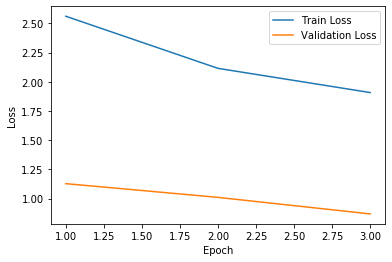

In [45]:
plt.plot(range(1, num_epochs+1), train_loss_per_epoch, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_loss_per_epoch, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()